Column names: ['Shared reactions', '% of reactions that are essential for growth under control and drought in a pathway', 'Log2 FC of drought/control of the entire pathway genes from the bulk RNA seq', 'differential gene expression p value', 'Log2 fold change of average flux of a pathway in the FBA model', 'model flux p value']
Number of pathways: 12
First few pathways: ['UDP-alpha-D-galactose biosynthesis', 'L-alanine degradation II ', 'Pyrimidine deoxyribonucleosides salvage']
Y positions: [0, 1, 2]
Y labels set: 12 labels
Pathways: ['UDP-alpha-D-galactose biosynthesis', 'L-alanine degradation II ', 'Pyrimidine deoxyribonucleosides salvage']


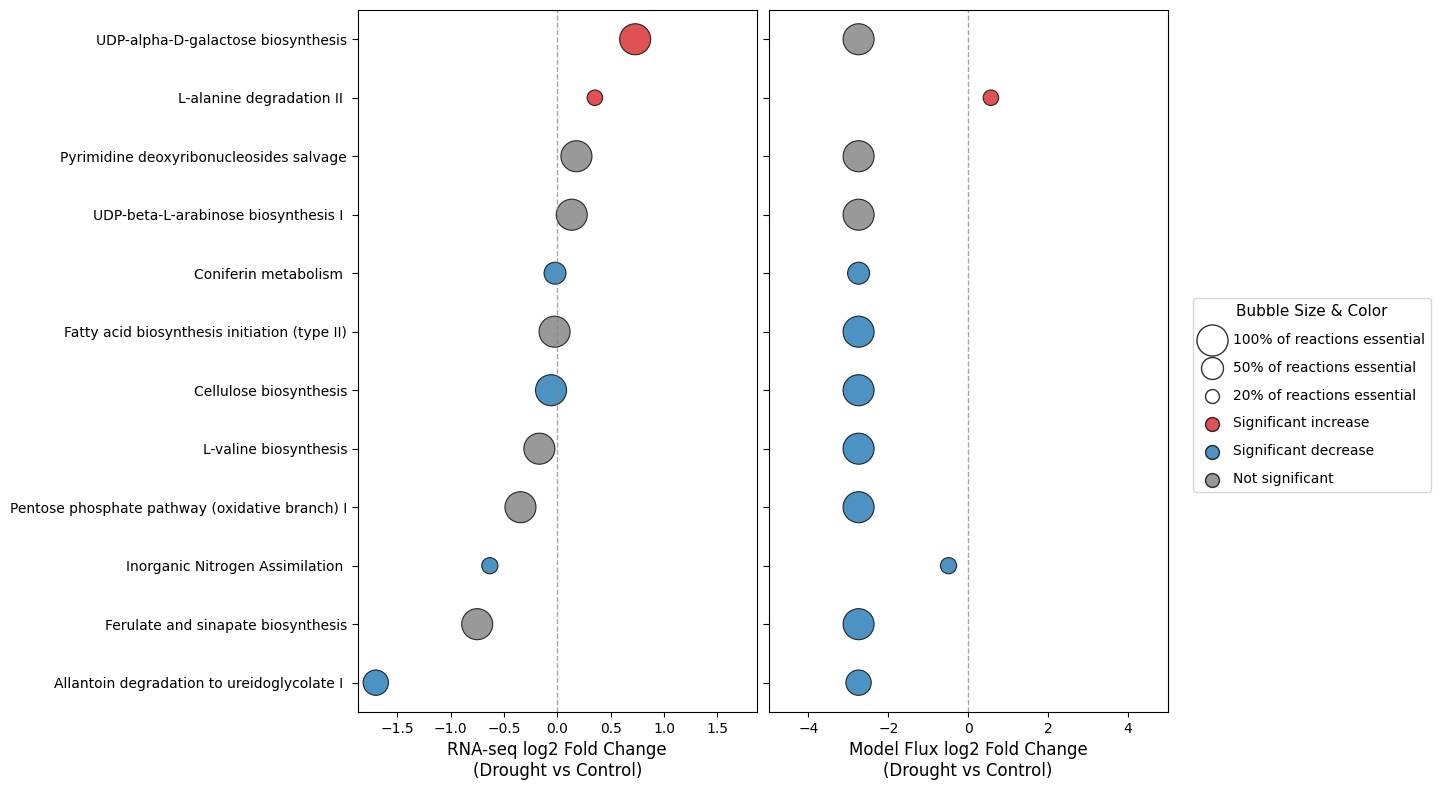


Number of pathways plotted: 12
RNA log2FC range: -1.700 to 0.730
Flux log2FC range: -2.744 to 0.571
% Essential range: 25.0% to 100.0%

Significant RNA-seq changes: 6/12
Significant Flux changes: 9/12


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# Load significant pathways from Excel file
df = pd.read_excel('bubble_plot_pathways.xlsx')

# Check column names and adjust if needed
print("Column names:", df.columns.tolist())

# If columns don't have headers or have different names, assign them
if len(df.columns) == 6:
    df.columns = ['Pathway', '%_Essential', 'RNA_log2FC', 'pvalue_RNA', 'Flux_log2FC', 'pvalue_flux']

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Filter out empty pathways
df = df[df['Pathway'].notna() & (df['Pathway'].str.strip() != '')]

# Convert to proper types
df['%_Essential'] = pd.to_numeric(df['%_Essential'], errors='coerce')
df['RNA_log2FC'] = pd.to_numeric(df['RNA_log2FC'], errors='coerce')
df['Flux_log2FC'] = pd.to_numeric(df['Flux_log2FC'], errors='coerce')
df['pvalue_RNA'] = pd.to_numeric(df['pvalue_RNA'], errors='coerce')
df['pvalue_flux'] = pd.to_numeric(df['pvalue_flux'], errors='coerce')

# Remove any rows with NaN values in critical columns
df = df.dropna(subset=['%_Essential', 'RNA_log2FC', 'Flux_log2FC', 'pvalue_RNA', 'pvalue_flux'])

# Define significance threshold
significance_threshold = 0.05

# Function to determine bubble color based on significance and direction
def get_bubble_color(log2fc, pvalue):
    if pvalue < significance_threshold:
        if log2fc > 0:
            return '#d62728'  # Red for significant increase
        else:
            return '#1f77b4'  # Blue for significant decrease
    else:
        return '#808080'  # Grey for not significant

# Add color columns for RNA and Flux
df['RNA_color'] = df.apply(lambda row: get_bubble_color(row['RNA_log2FC'], row['pvalue_RNA']), axis=1)
df['Flux_color'] = df.apply(lambda row: get_bubble_color(row['Flux_log2FC'], row['pvalue_flux']), axis=1)

# Sort pathways by RNA-seq log2 Fold Change (descending)
df = df.sort_values('RNA_log2FC', ascending=False)

# Extract variables
pathways = df['Pathway'].tolist()  # Convert to list
growth_percent = df['%_Essential'].values
rna_log2fc = df['RNA_log2FC'].values
flux_log2fc = df['Flux_log2FC'].values
rna_colors = df['RNA_color'].values
flux_colors = df['Flux_color'].values

# Debug print
print(f"Number of pathways: {len(pathways)}")
print(f"First few pathways: {pathways[:3] if len(pathways) > 0 else 'None'}")

# Bubble size scaling
bubble_scale = 5
bubble_sizes = growth_percent * bubble_scale

# Create figure with subplots - make it even wider for more legend space
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# RNA-seq plot (left)
y_positions = list(range(len(pathways)))
scatter1 = ax1.scatter(rna_log2fc, y_positions, s=bubble_sizes,
                      c=rna_colors, edgecolor='k', linewidth=0.8, alpha=0.8)

# Model Flux plot (right)
scatter2 = ax2.scatter(flux_log2fc, y_positions, s=bubble_sizes,
                      c=flux_colors, edgecolor='k', linewidth=0.8, alpha=0.8)

# Add vertical dashed lines at x = 0
ax1.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax2.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Set up y-axis for both plots
ax1.set_ylim(-0.5, len(pathways) - 0.5)
ax2.set_ylim(-0.5, len(pathways) - 0.5)

# Set y-axis labels (only on left plot)
ax1.set_yticks(y_positions)
ax1.set_yticklabels(pathways, fontsize=10)
ax1.invert_yaxis()

# Right plot - no labels but same ticks
ax2.set_yticks(y_positions)
ax2.set_yticklabels([])
ax2.invert_yaxis()

# Make sure y-axis is visible on left plot
ax1.tick_params(axis='y', which='major', labelsize=10, length=4)
ax2.tick_params(axis='y', which='major', length=4)

# Debug: Print y-axis info
print(f"Y positions: {y_positions[:3]}")
print(f"Y labels set: {len(pathways)} labels")
print(f"Pathways: {pathways[:3] if pathways else 'No pathways'}")

# Axis labels
ax1.set_xlabel('RNA-seq log2 Fold Change\n(Drought vs Control)', fontsize=12)
ax2.set_xlabel('Model Flux log2 Fold Change\n(Drought vs Control)', fontsize=12)

# Set x-axis limits to be symmetric around 0
max_rna = max(abs(rna_log2fc.min()), abs(rna_log2fc.max())) * 1.1
max_flux = max(abs(flux_log2fc.min()), abs(flux_log2fc.max())) * 1.1
ax1.set_xlim(-max_rna, max_rna)
ax2.set_xlim(-5, 5)

# Create legend for bubble size with shorter labels
legend_percents = [100, 50, 20]
legend_sizes = [p * bubble_scale for p in legend_percents]
size_handles = [
    plt.scatter([], [], s=size, c='white', edgecolors='k', alpha=0.8)
    for size in legend_sizes
]
# Your original longer labels
size_labels = [f'{p}% of reactions essential' for p in legend_percents]

# Create legend for colors with full words
color_handles = [
    plt.scatter([], [], s=100, c='#d62728', edgecolors='k', alpha=0.8),  # Red
    plt.scatter([], [], s=100, c='#1f77b4', edgecolors='k', alpha=0.8),  # Blue
    plt.scatter([], [], s=100, c='#808080', edgecolors='k', alpha=0.8)   # Grey
]
color_labels = ['Significant increase', 'Significant decrease', 'Not significant']

# Combine handles and labels
all_handles = size_handles + color_handles
all_labels = size_labels + color_labels

# Add legend to the right with wider gap
legend = fig.legend(
    all_handles, all_labels,
    scatterpoints=1,
    frameon=True,
    fontsize=10,
    loc='center right',
    bbox_to_anchor=(0.85, 0.5),
    title='Bubble Size & Color',
    title_fontsize=11,
    labelspacing=1.0,
    handletextpad=0.5,
    borderaxespad=0.5
)

# Adjust layout with wider gap between plots and legend
plt.tight_layout()
plt.subplots_adjust(right=0.70, left=0.25)  # Much more space between plots and legend

# Save figure
plt.savefig("dual_bubble_plot_pathways.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"\nNumber of pathways plotted: {len(df)}")
print(f"RNA log2FC range: {rna_log2fc.min():.3f} to {rna_log2fc.max():.3f}")
print(f"Flux log2FC range: {flux_log2fc.min():.3f} to {flux_log2fc.max():.3f}")
print(f"% Essential range: {growth_percent.min():.1f}% to {growth_percent.max():.1f}%")

# Print significance summary
rna_sig = sum(df['pvalue_RNA'] < significance_threshold)
flux_sig = sum(df['pvalue_flux'] < significance_threshold)
print(f"\nSignificant RNA-seq changes: {rna_sig}/{len(df)}")
print(f"Significant Flux changes: {flux_sig}/{len(df)}")